# Credit Card Fraud Detection

***By Joe Corliss***

**July 12, 2018**

## Contents

* [1. Introduction](#1)
    * [1.1 References](#1.1)
* [2. Getting Started](#2)
* [3. Train/Test Split](#3)
* [4. Exploratory Data Analysis](#4)
    * [4.1 Time](#4.1)
    * [4.2 Amount](#4.2)
    * [4.3 Time vs. Amount](#4.3)
    * [4.4 V1-V28](#4.4)
* [5. Mutual Information between Fraud and the Predictors](#5)
* [6. Modeling](#6)
    * [6.1 Logistic Regression and Support Vector Classifier](#6.1)
    * [6.2 Random Forest](#6.2)
* [7. Test Set Evaluation of the Best Model](#7)
* [8. Conclusion](#8)

# 1. Introduction
<a id='1'></a>

In this project we analyze a dataset of credit card transactions made over a two-day period in September 2013 by European cardholders. The dataset contains 284,807 transactions, of which 492 (0.17%) are fraudulent.

Each transaction has 30 features, all of which are numerical. The features `V1, V2, ..., V28` are the result of a PCA transformation. To protect confidentiality, background information on these features is not available. The `Time` feature contains the time elapsed since the first transaction, and the `Amount` feature contains the transaction amount. The response variable, `Class`, is 1 in the case of fraud, and 0 otherwise.

Our goal in this project is to construct models to predict whether a credit card transaction is fraudulent. We'll attempt a supervised learning approach. We'll also create visualizations to help us understand the structure of the data and unearth any interesting patterns.

## 1.1 References
<a id='1.1'></a>

* [Kaggle Dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud)
* [Kaggle Notebook](https://www.kaggle.com/pileatedperch/linear-svc-random-forest-mcc-0-77-0-88) - A version of this notebook hosted on Kaggle
* [GitHub Repository](https://github.com/jgcorliss/credit-card-fraud) - The GitHub repository for this project

# 2. Getting Started
<a id='2'></a>

Import basic libraries:

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

Read in the data into a pandas dataframe.

In [2]:
transactions = pd.read_csv('creditcard.csv')

Check basic metadata.

In [3]:
transactions.shape

(284807, 31)

In [4]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

Are there any variables with missing data?

In [5]:
transactions.isnull().any().any()

False

No! Let's view five randomly chosen transactions.

In [6]:
transactions.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
44333,41902.0,1.426789,-0.289653,-0.293921,-0.854916,-0.347593,-0.875710,-0.079200,-0.290741,-1.514316,0.831167,1.317719,0.401731,0.913439,0.128705,-0.344279,0.979761,-0.008560,-1.100156,1.041998,0.141685,0.230861,0.603798,-0.228516,0.068474,0.833699,-0.084813,-0.027933,-0.009602,15.00,0
88220,62045.0,-1.547243,0.545354,0.859257,0.123138,0.717430,0.576993,-0.095498,0.894938,-0.505093,-0.792845,0.921223,0.613913,0.173313,-0.043077,1.961134,-0.843320,1.468752,-2.147582,-1.711721,-0.246343,-0.108475,-0.082428,0.776363,-0.697407,-0.360761,0.194114,0.144210,-0.045002,10.02,0
163529,116009.0,1.938140,1.187440,-1.899462,4.025949,1.288608,-0.414337,0.497139,-0.165422,-1.104224,0.293627,-0.882977,-0.659773,0.357673,-2.622642,-0.598708,1.847255,1.142095,0.566562,-1.487492,-0.155628,-0.461225,-1.287327,0.216202,-0.962343,-0.152333,-0.302764,-0.002987,0.013085,12.71,0
4935,4485.0,-3.331309,2.636961,0.864133,-2.595668,-0.376151,-1.220749,1.080725,-0.934314,3.395773,4.713090,0.553346,-3.661955,0.595038,-0.284463,-0.669438,-1.323991,-0.521506,1.010299,-3.097186,1.325893,-1.106122,-1.125332,-0.022219,0.194881,0.313982,-0.024641,0.680543,0.076802,2.00,0
79955,58265.0,1.542993,-0.857281,-0.467534,-1.726643,-0.511416,-0.301089,-0.515731,-0.213958,-2.492096,1.591873,0.413440,-0.083626,1.340713,-0.077523,-0.405846,-0.156605,-0.067694,0.215438,0.749032,-0.194340,-0.507932,-1.163368,-0.033556,-0.875691,0.485193,-0.399461,-0.000999,-0.000867,36.47,0


How balanced are the classes, i.e. how common are fraudulent transactions?

In [7]:
transactions['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [8]:
transactions['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

Only 0.17% (492 out of 284,807) transactions are fraudulent.

# 3. Train/Test Split
<a id='3'></a>

Before we begin preprocessing, we split off a test data set. First split the data into features and response variable:

In [9]:
X = transactions.drop(labels='Class', axis=1) # Features
y = transactions.loc[:,'Class']               # Response
del transactions                              # Delete the original data

We'll use a test size of 20%. We also stratify the split on the response variable, which is very important to do because there are so few fraudulent transactions.

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
del X, y

In [12]:
X_train.shape

(227845, 30)

In [13]:
X_test.shape

(56962, 30)

In [14]:
# Prevent view warnings
X_train.is_copy = False
X_test.is_copy = False

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


# 4. Exploratory Data Analysis
<a id='4'></a>

We conduct EDA only on the training set, and leave the test set unknown.

## 4.1 Time
<a id='4.1'></a>

Few descriptive statistics for the `Time` variable:

In [15]:
X_train['Time'].describe()

count    227845.000000
mean      94707.617670
std       47523.204111
min           0.000000
25%       54086.000000
50%       84609.000000
75%      139261.000000
max      172792.000000
Name: Time, dtype: float64

Let's convert the time from seconds to hours to ease the interpretation.

In [16]:
X_train.loc[:,'Time'] = X_train.Time / 3600
X_test.loc[:,'Time'] = X_test.Time / 3600

What is the time of the last transaction, in days?

In [17]:
X_train['Time'].max() / 24

1.9999074074074075

So the transactions indeed occur over a two-day period. Next let's plot a histogram of transaction times, with one bin per hour:

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Transaction Times')

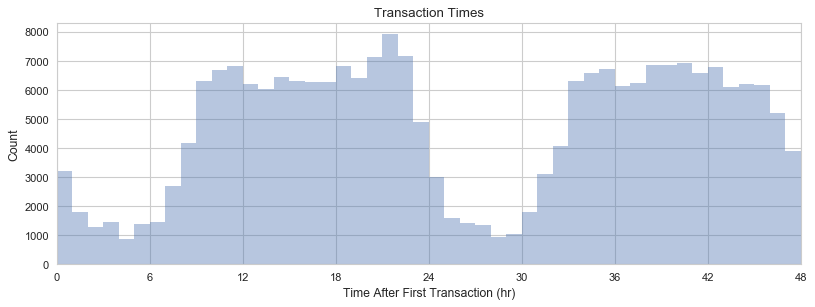

In [18]:
plt.figure(figsize=(12,4), dpi=80)
sns.distplot(X_train['Time'], bins=48, kde=False)
plt.xlim([0,48])
plt.xticks(np.arange(0,54,6))
plt.xlabel('Time After First Transaction (hr)')
plt.ylabel('Count')
plt.title('Transaction Times')

It looks like there are two lulls in credit card transactions during nighttime on each day.

## 4.2 Amount
<a id='4.2'></a>

Summary statistics:

In [19]:
X_train['Amount'].describe()

count    227845.000000
mean         88.709296
std         250.026305
min           0.000000
25%           5.550000
50%          22.000000
75%          77.890000
max       25691.160000
Name: Amount, dtype: float64

Comparing the different quantiles, it looks like the amounts are very right-skewed. To verify this, plot a histogram of the transaction amounts:

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Transaction Amounts')

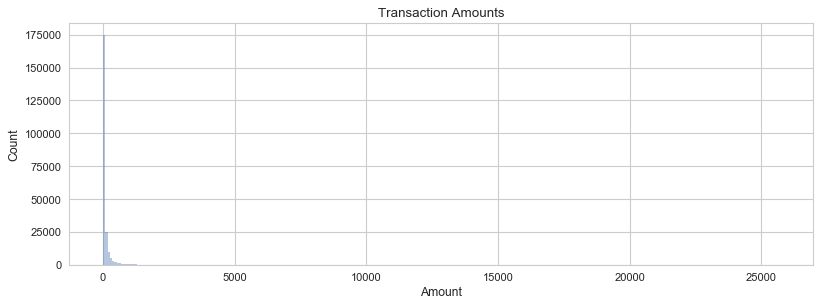

In [20]:
plt.figure(figsize=(12,4), dpi=80)
sns.distplot(X_train['Amount'], bins=300, kde=False)
plt.ylabel('Count')
plt.title('Transaction Amounts')

The histogram is hard to read due to some outliers we can't see. A boxplot will show the outliers:

Text(0.5,1,'Transaction Amounts')

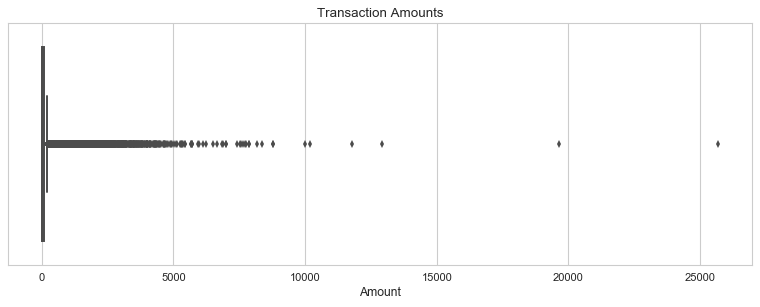

In [21]:
plt.figure(figsize=(12,4), dpi=80)
sns.boxplot(X_train['Amount'])
plt.title('Transaction Amounts')

We can see there are no outliers on the left and many outliers on the right. So the amounts certainly seem right-skewed. We can calculate the skewness to be sure:

In [22]:
X_train['Amount'].skew()

16.910303546516744

That's a strong right skew. Let's use a power transform to bring the transaction amounts closer to a normal distribution. We'll use the [Box-Cox transform in SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html), but some of the amounts are zero (min = 0 above), so we need to shift the amounts first to make them positive. We'll shift by a very small amount, just $10^{-9}$.

In [23]:
X_train.loc[:,'Amount'] = X_train['Amount'] + 1e-9 # Shift all amounts by 1e-9

Perform the Box-Cox transform:

In [24]:
X_train.loc[:,'Amount'], maxlog, (min_ci, max_ci) = sp.stats.boxcox(X_train['Amount'], alpha=0.01)

The maximum likelihood estimate of $\lambda$ in the Box-Cox transform:

In [25]:
maxlog

0.13436569191158662

The 99% confidence interval for $\lambda$:

In [26]:
(min_ci, max_ci)

(0.13291390124729957, 0.1358266545085391)

Plot the newly transformed amounts:

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Transaction Amounts (Box-Cox Transformed)')

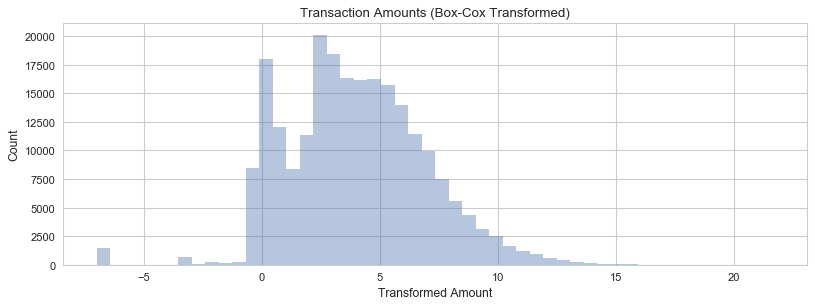

In [27]:
plt.figure(figsize=(12,4), dpi=80)
sns.distplot(X_train['Amount'], kde=False)
plt.xlabel('Transformed Amount')
plt.ylabel('Count')
plt.title('Transaction Amounts (Box-Cox Transformed)')

Much better. The distribution appears to be bimodal, suggesting a divide between "small" and "large" purchases. Now let's check the descriptive stats of the transformed amounts:

In [28]:
X_train['Amount'].describe()

count    227845.000000
mean          3.985515
std           2.972505
min          -6.982733
25%           1.927181
50%           3.831861
75%           5.919328
max          21.680566
Name: Amount, dtype: float64

What's the skewness of the transformed amounts? (Zero skewness would be ideal.)

In [29]:
X_train['Amount'].skew()

0.11421481857917302

So our power transform removed most of the skewness in the `Amount` variable. Now we need to compute the Box-Cox transform on the test data amounts as well, using the $\lambda$ value estimated on the training data.

In [30]:
X_test.loc[:,'Amount'] = X_test['Amount'] + 1e-9 # Shift all amounts by 1e-9

In [31]:
X_test.loc[:,'Amount'] = sp.stats.boxcox(X_test['Amount'], lmbda=maxlog)

## 4.3 Time vs. Amount
<a id='4.3'></a>

Is there a relationship between the transaction amounts and the time of day? Let's explore this question with a joint histogram using hexagonal bins. For this plot, we convert each transaction time to the hour of the day on which it occurred.

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


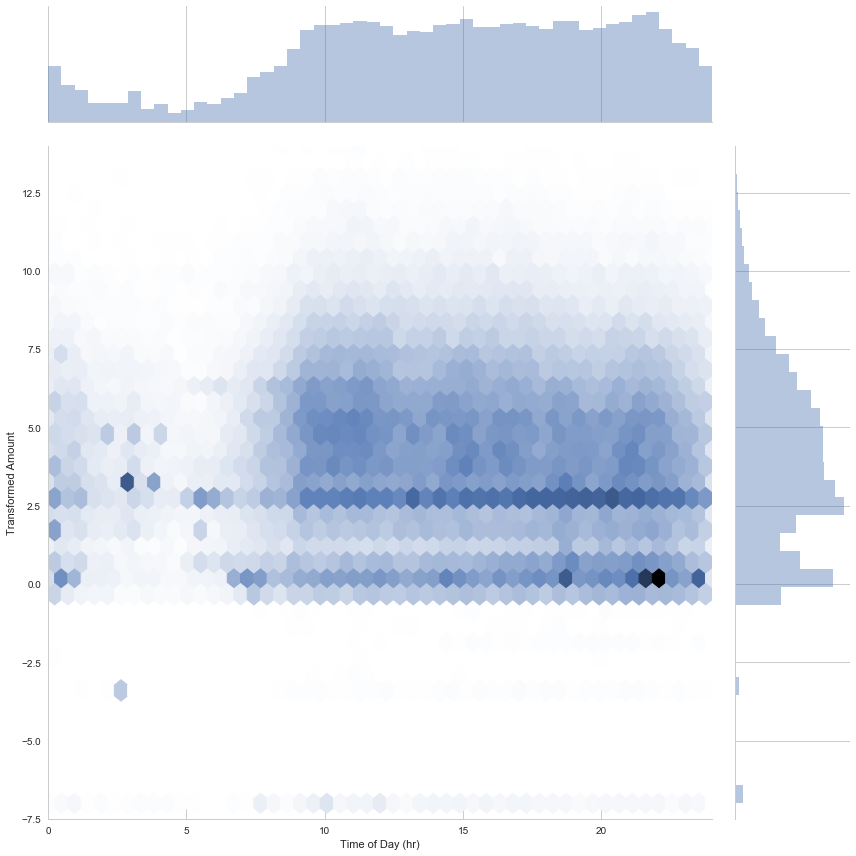

In [32]:
sns.jointplot(X_train['Time'].apply(lambda x: x % 24), X_train['Amount'], kind='hex', stat_func=None, size=12, xlim=(0,24), ylim=(-7.5,14)).set_axis_labels('Time of Day (hr)','Transformed Amount')

The transaction amounts appear to be similarly distributed throughout the daytime hours. However, in the earliest hours of the day, around 5-7 AM, amounts around 2.5 are the most common (recall this is a Box-Cox transformed value). Perhaps everyone's buying their morning coffee?

## 4.4 V1-V28
<a id='4.4'></a>

Let's compare the descriptive stats of the PCA variables `V1-V28`.

In [33]:
pca_vars = ['V%i' % k for k in range(1,29)]

Full table of descriptive stats:

In [34]:
X_train[pca_vars].describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000
mean,-0.000713,-0.001034,0.002557,0.003839,-0.002857,0.002085,0.000022,0.000093,0.000243,-0.000363,0.000651,-0.000834,-0.000976,0.002291,-0.000595,-0.000499,0.000587,0.001448,-0.000146,-0.000796,0.000023,0.000897,0.000765,-0.000380,0.000136,-0.000301,-0.000046,-0.000027
std,1.952399,1.636689,1.514288,1.417086,1.383532,1.333769,1.240239,1.200348,1.096453,1.082580,1.020932,1.000266,0.996678,0.957485,0.916946,0.876978,0.846748,0.838169,0.815140,0.767956,0.733325,0.725353,0.616772,0.605741,0.522184,0.482187,0.405182,0.331048
min,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.431131,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.335193,-7.213527,-54.497720,-34.830382,-10.933144,-36.666000,-2.836627,-8.696627,-2.534330,-22.565679,-15.430084
25%,-0.922830,-0.599928,-0.887861,-0.844052,-0.693702,-0.766195,-0.555377,-0.208302,-0.642006,-0.535079,-0.761255,-0.406597,-0.650225,-0.423563,-0.584357,-0.469513,-0.484153,-0.497660,-0.456946,-0.212129,-0.227952,-0.541079,-0.162242,-0.354208,-0.317488,-0.327576,-0.070767,-0.053013
50%,0.016743,0.064370,0.180865,-0.016750,-0.055388,-0.271706,0.039185,0.022594,-0.051224,-0.091877,-0.032213,0.141227,-0.014920,0.051939,0.047181,0.066080,-0.065260,-0.001867,0.004371,-0.062809,-0.029095,0.007661,-0.011184,0.040977,0.017081,-0.052599,0.001373,0.011255
75%,1.315147,0.801738,1.027592,0.746907,0.611056,0.401204,0.569307,0.328079,0.596563,0.455577,0.740921,0.617925,0.663521,0.495181,0.649788,0.522836,0.400067,0.501554,0.459695,0.132873,0.186678,0.529342,0.147825,0.438432,0.351400,0.240554,0.091028,0.078341
max,2.451888,22.057729,9.382558,16.715537,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315112,9.207059,5.041069,5.591971,39.420904,27.202839,10.503090,22.083545,4.584549,7.519589,3.517346,31.612198,33.847808


It's tedious to interpret this table, so let's make some visualizations. We'll start by plotting the means:

Text(0.5,1,'V1-V28 Means')

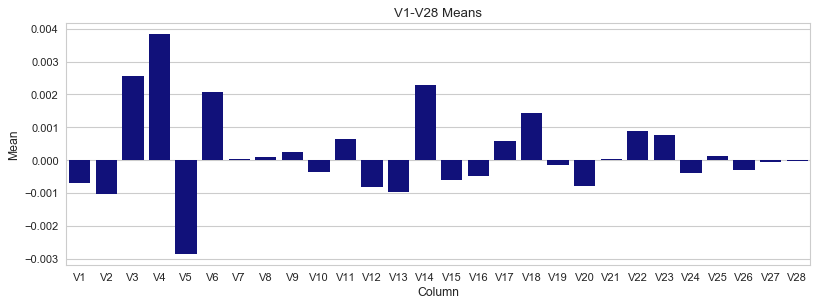

In [35]:
plt.figure(figsize=(12,4), dpi=80)
sns.barplot(x=pca_vars, y=X_train[pca_vars].mean(), color='darkblue')
plt.xlabel('Column')
plt.ylabel('Mean')
plt.title('V1-V28 Means')

All of `V1-V28` have approximately zero mean. Now plot the standard deviations:

Text(0.5,1,'V1-V28 Standard Deviations')

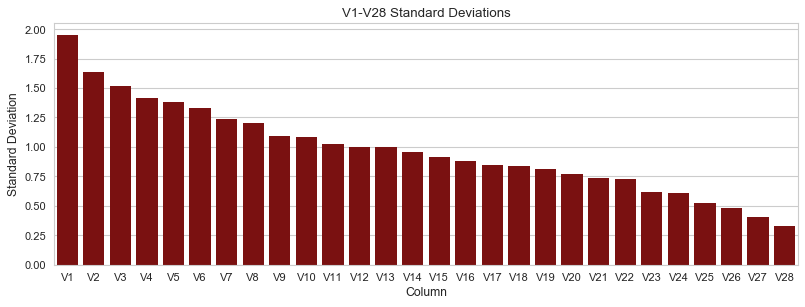

In [36]:
plt.figure(figsize=(12,4), dpi=80)
sns.barplot(x=pca_vars, y=X_train[pca_vars].std(), color='darkred')
plt.xlabel('Column')
plt.ylabel('Standard Deviation')
plt.title('V1-V28 Standard Deviations')

The PCA variables have roughly unit variance, but as low as ~0.3 and as high as ~1.9. Plot the skewnesses next:

Text(0.5,1,'V1-V28 Skewnesses')

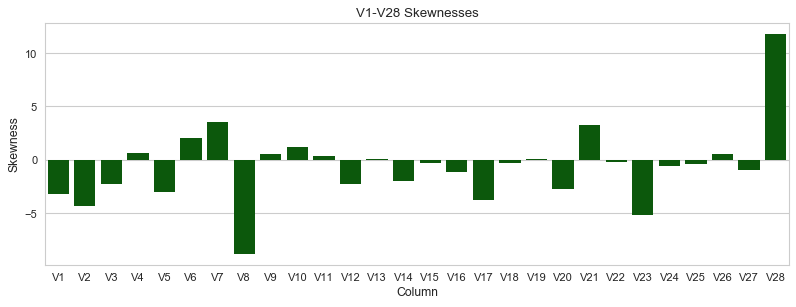

In [37]:
plt.figure(figsize=(12,4), dpi=80)
sns.barplot(x=pca_vars, y=X_train[pca_vars].skew(), color='darkgreen')
plt.xlabel('Column')
plt.ylabel('Skewness')
plt.title('V1-V28 Skewnesses')

A few of the PCA variables are significantly skewed. Let's plot a histogram of one of the particularly skewed variables, `V8`, to see the distribution in detail.

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'V8')

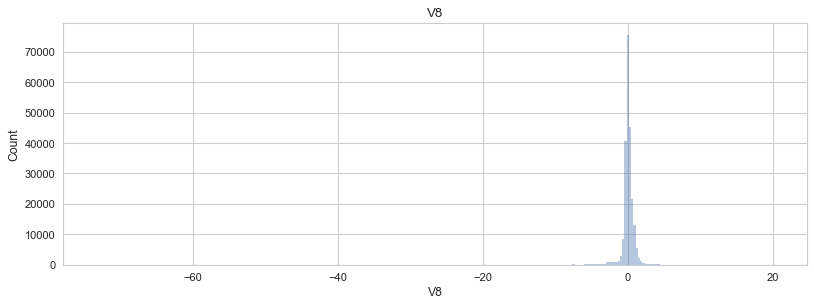

In [38]:
plt.figure(figsize=(12,4), dpi=80)
sns.distplot(X_train['V8'], bins=300, kde=False)
plt.ylabel('Count')
plt.title('V8')

The histogram doesn't show us outliers. Let's try a boxplot:

Text(0.5,1,'V8')

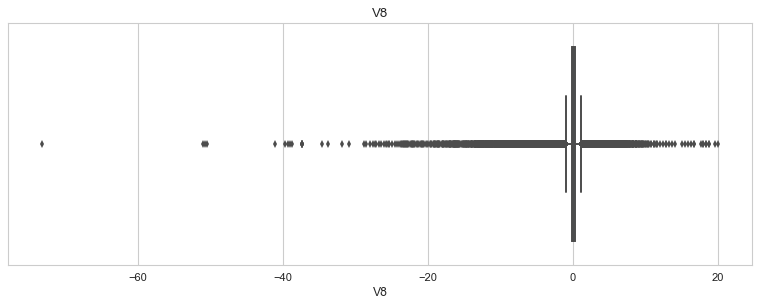

In [39]:
plt.figure(figsize=(12,4), dpi=80)
sns.boxplot(X_train['V8'])
plt.title('V8')

The boxplot is also hard to read due to the large number of outliers, which indicates high kurtosis in `V8`. This motivates us to plot the kurtoses of the PCA variables. The kurtosis method employed in pandas is Fisher’s definition, for which the standard normal distribution has kurtosis 0.

Note the log scale on the y-axis in the plot below:

Text(0.5,1,'V1-V28 Kurtoses')

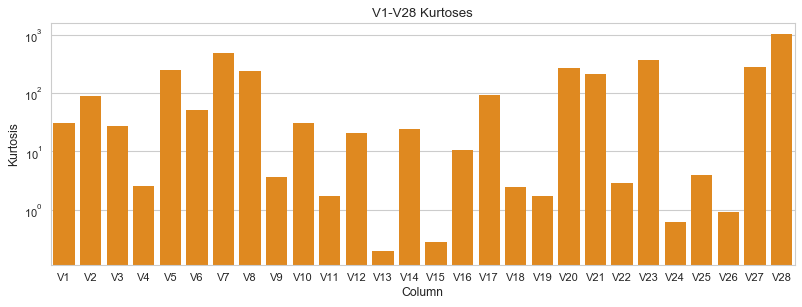

In [40]:
plt.figure(figsize=(12,4), dpi=80)
plt.yscale('log')
sns.barplot(x=pca_vars, y=X_train[pca_vars].kurtosis(), color='darkorange')
plt.xlabel('Column')
plt.ylabel('Kurtosis')
plt.title('V1-V28 Kurtoses')

We've learned that many of the PCA variables are heavy-tailed. The large numbers of outliers in `V1-V28` motivates us to consider robust descriptive statistics. Let's plot the medians:

Text(0.5,1,'V1-V28 Medians')

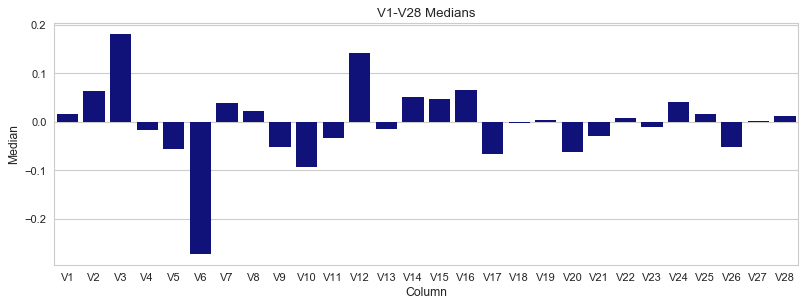

In [41]:
plt.figure(figsize=(12,4), dpi=80)
sns.barplot(x=pca_vars, y=X_train[pca_vars].median(), color='darkblue')
plt.xlabel('Column')
plt.ylabel('Median')
plt.title('V1-V28 Medians')

The medians are also roughly zero. Next let's look at the interquartile ranges (IQR)*:

*Pandas does not have a built-in IQR method, but we can use the [`quantile`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.quantile.html) method to calculate the IQR.

Text(0.5,1,'V1-V28 IQRs')

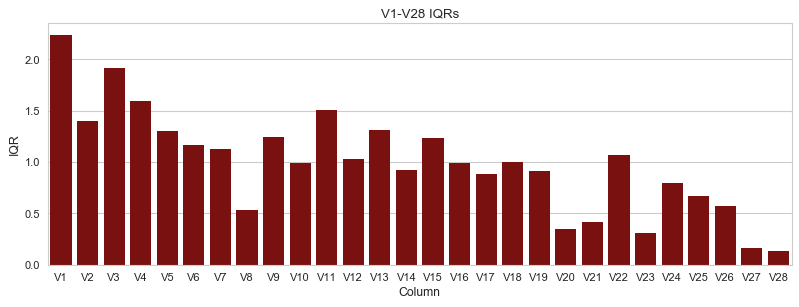

In [42]:
plt.figure(figsize=(12,4), dpi=80)
sns.barplot(x=pca_vars, y=X_train[pca_vars].quantile(0.75) - X_train[pca_vars].quantile(0.25), color='darkred')
plt.xlabel('Column')
plt.ylabel('IQR')
plt.title('V1-V28 IQRs')

The IQRs of `V1-V28` are on a similar scale as the standard deviations.

# 5. Mutual Information between Fraud and the Predictors
<a id='5'></a>

[Mutual information](https://en.wikipedia.org/wiki/Mutual_information) is a non-parametric method to estimate the mutual dependence between two variables. Mutual information of 0 indicates no dependence, and higher values indicate higher dependence. According to the [sklearn User Guide](http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection), "mutual information methods can capture any kind of statistical dependency, but being nonparametric, they require more samples for accurate estimation." We have 227,845 training samples, so mutual information should work well. Because the target variable is discrete, we use [`mutual_info_classif`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif) (as opposed to [`mutual_info_regression`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression) for a continuous target).

In [43]:
from sklearn.feature_selection import mutual_info_classif

In [44]:
mutual_infos = pd.Series(data=mutual_info_classif(X_train, y_train, discrete_features=False, random_state=1), index=X_train.columns)

The calculated mutual informations of each variable with `Class`, in descending order:

In [45]:
mutual_infos.sort_values(ascending=False)

V17       0.008037
V14       0.007977
V10       0.007354
V12       0.007354
V11       0.006607
V16       0.005793
V4        0.004843
V3        0.004755
V18       0.004025
V9        0.003996
V7        0.003941
V2        0.003085
V21       0.002304
V27       0.002271
V6        0.002265
V5        0.002254
V1        0.001990
V8        0.001843
V28       0.001757
Time      0.001722
Amount    0.001419
V19       0.001322
V20       0.001136
V23       0.000827
V24       0.000593
V26       0.000459
V22       0.000388
V25       0.000376
V15       0.000230
V13       0.000205
dtype: float64

The five most correlated variables with `Class` are, in decreasing order, V17, V14, V10, V12, and V11.

# 6. Modeling
<a id='6'></a>

Now we're ready to build machine learning models to predict whether a transaction is fraudulent. We'll train the following models:
* Logistic regression
* Support vector classifier
* Random forest

## 6.1 Logistic Regression and Support Vector Classifier
<a id='6.1'></a>

The class [`SGDClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) implements multiple linear classifiers with SGD training, which makes learning much faster on large datasets. We'll implement the model as a machine learning pipeline that includes [`StandardScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) for data standardization (rescaling each variable to zero mean and unit variance).

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

In [47]:
pipeline_sgd = Pipeline([
    ('scaler', StandardScaler(copy=False)),
    ('model', SGDClassifier(max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

We'll conduct a grid search over several hyperparameter choices. The search uses 5-fold cross-validation with stratified folds. The type of linear classifier is chosen with the `loss` hyperparameter. For a linear SVC we set `loss = 'hinge'`, and for logistic regression we set `loss = 'log'`.

Set the hyperparameter grids to search over, one grid for the linear SVC and one for logistic regression:

In [48]:
param_grid_sgd = [{
    'model__loss': ['log'],
    'model__penalty': ['l1', 'l2'],
    'model__alpha': np.logspace(start=-3, stop=3, num=20)
}, {
    'model__loss': ['hinge'],
    'model__alpha': np.logspace(start=-3, stop=3, num=20),
    'model__class_weight': [None, 'balanced']
}]

The grid search, implemented by [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), uses [`StratifiedKFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) with 5 folds for the train/validation splits. We'll use [`matthews_corrcoef`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) (the [Matthews correlation coefficient](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient), MCC) as our scoring metric.

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, matthews_corrcoef

In [50]:
MCC_scorer = make_scorer(matthews_corrcoef)
grid_sgd = GridSearchCV(estimator=pipeline_sgd, param_grid=param_grid_sgd, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

Perform the grid search:

In [51]:
import warnings
with warnings.catch_warnings(): # Suppress warnings from the matthews_corrcoef function
    warnings.simplefilter("ignore")
    grid_sgd.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.3min finished


Mean cross-validated MCC score of the best estimator found:

In [52]:
grid_sgd.best_score_

0.8075666039570759

This is a pretty good MCC score---random guessing has a score of 0, and a perfect predictor has a score of 1. Now check the best hyperparameters found in the grid search:

In [53]:
grid_sgd.best_params_

{'model__alpha': 483.2930238571752,
 'model__class_weight': 'balanced',
 'model__loss': 'hinge'}

So the linear SVC performed better than logistic regression, and with a high level of regularization ($\alpha\approx 483$).

## 6.2 Random Forest
<a id='6.2'></a>

Next we'll try a random forest model, implemented in [`RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [54]:
from sklearn.ensemble import RandomForestClassifier

We do not need to rescale the data for tree-based models, so our pipeline will simply consist of the random forest model. We'll leave the pipeline implementation in place in case we want to add preprocessing steps in the future.

In [55]:
pipeline_rf = Pipeline([
    ('model', RandomForestClassifier(n_jobs=-1, random_state=1))
])

The random forest takes much longer to train on this fairly large dataset, so we don't actually do a hyperparameter grid search, only specifiying the number of estimators. We'll leave the grid search implemented in case we decide to try different hyperparameter values in the future.

In [56]:
param_grid_rf = {'model__n_estimators': [75]}

In [57]:
grid_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

Perform the grid search:

In [58]:
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'model__n_estimators': [75]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=False,
       scoring=make_scorer(matthews_corrcoef), verbose=1)

In [59]:
grid_rf.best_score_

0.8567203839327452

The random forest performed much better than the linear SVC---and without any hyperparameter tweaking!

In [60]:
grid_rf.best_params_

{'model__n_estimators': 75}

# 7. Test Set Evaluation of the Best Model
<a id='7'></a>

According to the cross-validated MCC scores, the random forest is the best-performing model, so now let's evaluate its performance on the test set.

In [61]:
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, cohen_kappa_score, accuracy_score, average_precision_score, roc_auc_score

In [62]:
def classification_eval(estimator, X_test, y_test):
    """
    Print several metrics of classification performance of an estimator, given features X_test and true labels y_test.
    
    Input: estimator or GridSearchCV instance, X_test, y_test
    Returns: text printout of metrics
    """
    y_pred = estimator.predict(X_test)
    
    # Number of decimal places based on number of samples
    dec = np.int64(np.ceil(np.log10(len(y_test))))
    
    print('CONFUSION MATRIX')
    print(confusion_matrix(y_test, y_pred), '\n')
    
    print('CLASSIFICATION REPORT')
    print(classification_report(y_test, y_pred, digits=dec))
    
    print('SCALAR METRICS')
    format_str = '%%13s = %%.%if' % dec
    print(format_str % ('MCC', matthews_corrcoef(y_test, y_pred)))
    if y_test.nunique() <= 2: # Additional metrics for binary classification
        try:
            y_score = estimator.predict_proba(X_test)[:,1]
        except:
            y_score = estimator.decision_function(X_test)
        print(format_str % ('AUPRC', average_precision_score(y_test, y_score)))
        print(format_str % ('AUROC', roc_auc_score(y_test, y_score)))
    print(format_str % ("Cohen's kappa", cohen_kappa_score(y_test, y_pred)))
    print(format_str % ('Accuracy', accuracy_score(y_test, y_pred)))

Evaluate the random forest on the test set:

In [63]:
classification_eval(grid_rf, X_test, y_test)

CONFUSION MATRIX
[[56854    10]
 [   15    83]] 

CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0    0.99974   0.99982   0.99978     56864
          1    0.89247   0.84694   0.86911        98

avg / total    0.99955   0.99956   0.99956     56962

SCALAR METRICS
          MCC = 0.86919
        AUPRC = 0.85098
        AUROC = 0.95924
Cohen's kappa = 0.86889
     Accuracy = 0.99956


According to the MCC, the random forest performed better on the test set than on the training set. This is probably due to the refit model being trained on the entire training data set, and not on the smaller CV folds.

# 8. Conclusion
<a id='8'></a>

We were able to accurately identify fraudulent credit card transactions using a random forest model. We found that the five variables most correlated with fraud are, in decreasing order, V17, V14, V10, V12, and V11. Only a few preprocessing steps were necessary before constructing predictive models:
* Split the data using a random, stratified train/test split with a test size of 20%
* Box-Cox power transform of the transaction amounts to remove skewness in the data
* Mean and variance standardization of all features as part of a machine learning pipeline

We used the [Matthews correlation coefficient (MCC)](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient) to compare the performance of different models. In cross validation, the best linear model (logistic regression, linear SVC) achieved a cross-validated MCC score of 0.807, and a random forest achieved a cross-validated MCC score of 0.856. We therefore chose the random forest as the better model, which obtained an MCC of 0.869 on the test set.

To improve a chosen model, we searched over a grid of hyperparameters and compared performance with cross-validation. It may be possible to improve the random forest model by further tweaking the hyperparameters, given additional time and/or computational power.